# Machine Learning Applied to Forecasting: Weekly Electricity Production in Spain 2015-2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



Model building objectives:
* Train a Machine Learning model being able to forecast (predict on future data) 4 periods ahead
* Feature Engineering process is automatic and no assumptions on data statistical properties is required 
* Assessment will be carried out computing MAPE (Mean Absolute Percent Error)for each forecating horizong on a holdout dataset

Model assessment and residual analysis
$$ MAPE =\frac{1}{N} \sum_{i=1}^{N}\frac{|y-\hat{y}|}{y}$$

## Data

3 years weekly energy demand (MWh) in Spain

In [3]:
!head -5 ./data/energy_week.csv

date,energy
2015-01-11,4745922.7
2015-01-18,5059830.8
2015-01-25,5270079.5
2015-02-01,5373193.2


In [4]:
data = pd.read_csv("./data/energy_week.csv", parse_dates=["date"], index_col="date")
data = data.asfreq("W")
data.info()          

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190 entries, 2015-01-11 to 2018-08-26
Freq: W-SUN
Data columns (total 1 columns):
energy    190 non-null float64
dtypes: float64(1)
memory usage: 3.0 KB


In [5]:
data.tail()

,energy
date,
2018-07-29,4342904.3
2018-08-05,4649383.7
2018-08-12,4260483.2
2018-08-19,4126102.9
2018-08-26,4393094.5


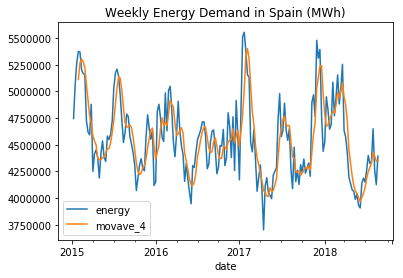

In [6]:
data["year"] = data.index.year
data["qtr"] = data.index.quarter
data["mon"] = data.index.month
data["week"] = data.index.week
data["ix"] = range(0,len(data))
data[["movave_4", "movstd_4"]] = data.energy.rolling(4).agg([np.mean, np.std])
data[["movave_12", "movstd_12"]] = data.energy.rolling(12).agg([np.mean, np.std])
data[["movave_52", "movstd_52"]] = data.energy.rolling(52).agg([np.mean, np.std])
data[["energy", "movave_4"]].plot(title="Weekly Energy Demand in Spain (MWh)")
plt.show()

## EDA: Exploratory Data Analysis

EDA Objectives:
* Is target variable normally distributed with constant volatility?
* Is there a seasonal pattern?
* Is there a trend pattern?


### Target Analyisis: Normality and Volatility

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


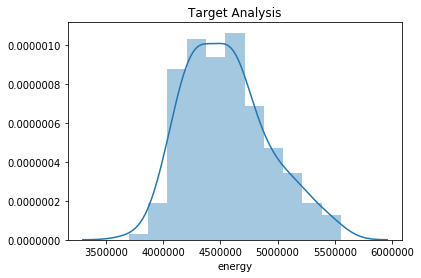

In [7]:
sns.distplot(data.energy)
plt.title("Target Analysis")
plt.show()

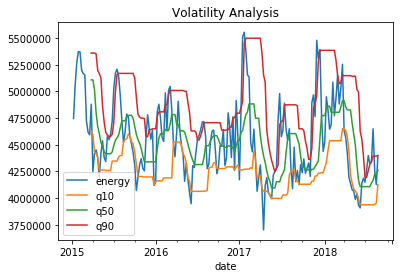

In [8]:
# Insert the rolling quantiles to the monthly returns
data_rolling = data.energy.rolling(window=12)
data['q10'] = data_rolling.quantile(0.1).to_frame("q10")
data['q50'] = data_rolling.quantile(0.5).to_frame("q50")
data['q90'] = data_rolling.quantile(0.9).to_frame("q90")

data[["energy", "q10", "q50", "q90"]].plot(title="Volatility Analysis")
plt.show()

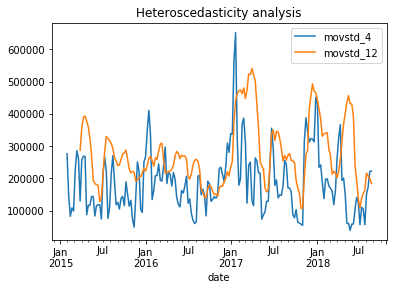

In [9]:
data[["movstd_4", "movstd_12"]].plot(title="Heteroscedasticity analysis")
plt.show()

### Time Series Analysis: Seasonality

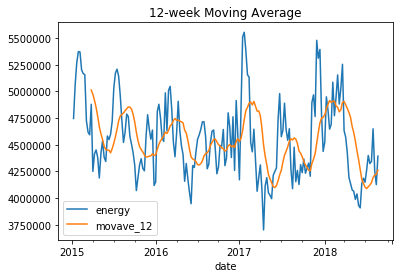

In [10]:
data[["energy", "movave_12"]].plot(title="12-week Moving Average")
plt.show()

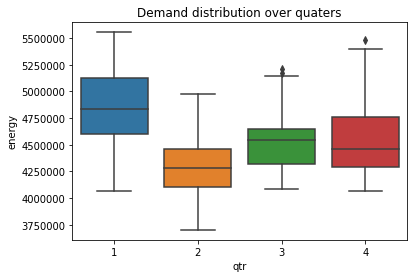

In [12]:
sns.boxplot(data=data, x="qtr", y="energy")
plt.title("Demand distribution over quaters")
plt.show()

### Time Series Analysis: Trend

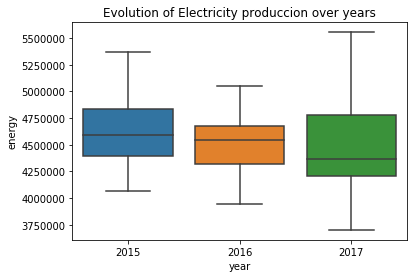

In [11]:
sns.boxplot(data=data["2015":"2017"], x="year", y="energy")
plt.title("Evolution of Electricity produccion over years")
plt.show()

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


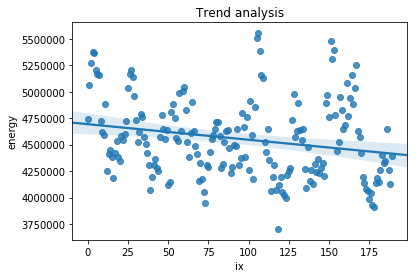

In [13]:
sns.regplot(data=data, x="ix", y="energy")
plt.title("Trend analysis")
plt.show()

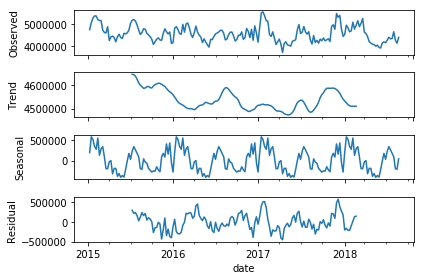

In [14]:
result = seasonal_decompose(data.energy, model="additive")
result.plot()
plt.show()

## Feature Engineering:

Extract features from past data in an automated way, and assess them.

* Lagged information
* Window stats


In [15]:
features = []
corr_features=[]
targets = []
tau = 5 #forecasting periods
for t in range(0,tau):
    data["target_t" + str(t)] = data.energy.shift(-t)
    targets.append("target_t" + str(t))
    
for t in range(1,7):
    data["feat_ar" + str(t)] = data.energy.shift(t)
    #data["feat_ar" + str(t) + "_lag52"] = data.energy.shift(52)
    features.append("feat_ar" + str(t))
    corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag52")
        
    
for t in [3, 6]:
    data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
# Use pandas' get_dummies function to get dummies for day of the week
months = pd.get_dummies(data.mon,
                              prefix="mon",
                              drop_first=True)
# Set the index as the original dataframe index for merging
months.index = data.index
# Join the dataframe with the days of week dataframe
data = pd.concat([data, months], axis=1)

features = features + months.columns.values.tolist()

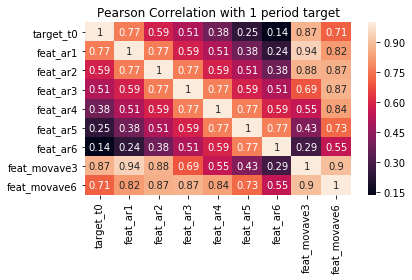

In [16]:
# Calculate correlation matrix
corr = data[["target_t0"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t0"].apply(abs).sort_values(ascending=False).index.values[:6]
top5_mostCorrFeats

# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation with 1 period target")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


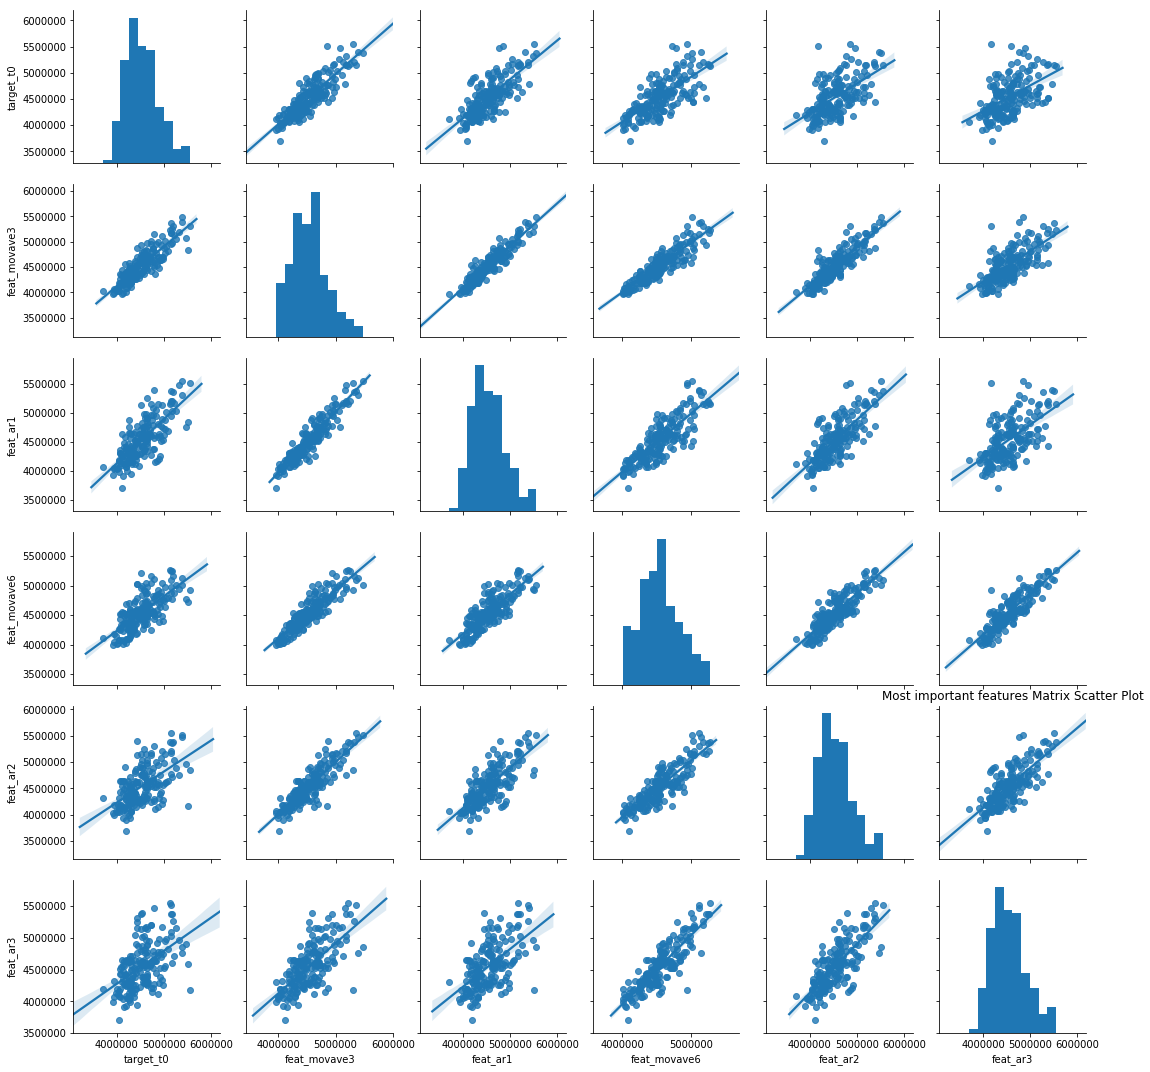

In [17]:
sns.pairplot(data=data[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

## Model Building

Linear Models:
* Relationships in data seem nearly lineal
* Data independency and multicollinearity
* Assumptions on target variable distribution

Tree based-models:
* Can model any kind of relationship
* Tools for regularization and generalization
* Bagging: Bootstrap aggregating

NN (Multilayer perceptron)
* Multiple neurons in the ouptut layer

Multi-output regression Frameworks:
* Fit a different model for every target

### Split Data

* Train: Model fitting
* Validate: Hyperparameter tunning
* Test: Model Assessment and residual analysis

In [18]:
train_size=0.8
val_size=0.1
data = data.dropna()
nobs= len(data)

train_ix_split = int(train_size*nobs)
val_ix_split = int((train_size+val_size)*nobs)


X_train = data.iloc[:train_ix_split][features]
y_train = data.iloc[:train_ix_split][targets]

X_val = data.iloc[train_ix_split:val_ix_split][features]
y_val = data.iloc[train_ix_split:val_ix_split][targets]

X_test = data.iloc[val_ix_split:][features]
y_test = data.iloc[val_ix_split:][targets]
print("Total number of observations: ", nobs)
print("Train: {}{},\nVal: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_val.shape, y_val.shape,
                                              X_test.shape, y_test.shape))

Total number of observations:  135
Train: (108, 25)(108, 5),
Val: (13, 25)(13, 5), 
Test: (14, 25)(14, 5)


### Baseline Model: Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
print("Train RSQ: ", reg.score(X_train, y_train))
print("Val RSQ: ", reg.score(X_val, y_val))

Train RSQ:  0.6976588516790019
Val RSQ:  0.45252262031417306


### Train a Random Forest:

### Single forecast-period model

In [20]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
grid = {"n_estimators": [500], 
        'max_depth': [3,5,10,20], 
        'max_features': [4, 8, 10, 19], 
        'random_state': [42]}

train_scores = []
val_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(X_train, y_train["target_t0"])
    train_scores.append(rfr.score(X_train, y_train["target_t0"]))
    val_scores.append(rfr.score(X_val, y_val["target_t0"]))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(val_scores)
print("Train RSQ: ",train_scores[best_idx], ParameterGrid(grid)[best_idx])
print("Val RSQ: ",val_scores[best_idx], ParameterGrid(grid)[best_idx])

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Train RSQ:  0.9629860153274087 {'random_state': 42, 'n_estimators': 500, 'max_features': 19, 'max_depth': 20}
Val RSQ:  0.6312186045296164 {'random_state': 42, 'n_estimators': 500, 'max_features': 19, 'max_depth': 20}


### Multiple forecast-period model

In [21]:
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
grid = {"n_estimators": [500], 
        'max_depth': [3,5,10,20], 
        'max_features': [4, 8, 10, 19], 
        'random_state': [42]}

train_scores = []
val_scores = []
models = []
# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(X_train, y_train)
    train_scores.append(rfr.score(X_train, y_train))
    val_scores.append(rfr.score(X_val, y_val))
    models.append(rfr)

# Find best hyperparameters from the test score and print
best_idx = np.argmax(val_scores)
best_model = models[best_idx]
print("Train RSQ: ",train_scores[best_idx], ParameterGrid(grid)[best_idx])
print("Val RSQ: ",val_scores[best_idx], ParameterGrid(grid)[best_idx])

Train RSQ:  0.8057144515223584 {'random_state': 42, 'n_estimators': 500, 'max_features': 19, 'max_depth': 5}
Val RSQ:  0.15246039959460156 {'random_state': 42, 'n_estimators': 500, 'max_features': 19, 'max_depth': 5}


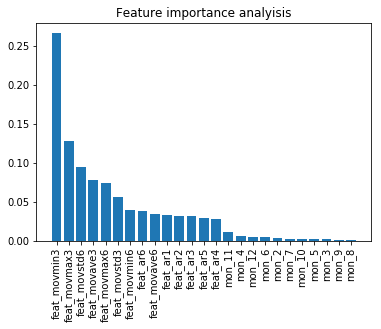

In [22]:
# Get feature importances from our random forest model
importances = best_model.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(features)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

Results are significantly different than the set of features yielded by correlation analysis, showing that complex relationships and interactions may impact model performance

## Model Assessment:

### Performance Metrics: MAPE

In [23]:
train_pred = best_model.predict(X_train)
val_pred = best_model.predict(X_val) 
test_pred = best_model.predict(X_test)

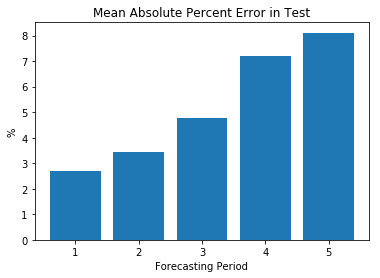

In [24]:
train_mape = []
val_mape = []
test_mape = []
periods = list( range(0,tau))
for t in periods:
    train_mape.append(np.mean(abs(y_train["target_t" + str(t)]- train_pred[:,t])/y_train["target_t0"], axis=0)*100)
    val_mape.append(np.mean(abs(y_val["target_t" + str(t)]- val_pred[:,t])/y_val["target_t0"], axis=0)*100)
    test_mape.append(np.mean(abs(y_test["target_t" + str(t)]- test_pred[:,t])/y_test["target_t0"], axis=0)*100)
periods_tickers= list(map(lambda x: x+1, periods))
plt.bar(periods_tickers,test_mape)
plt.title("Mean Absolute Percent Error in Test")
plt.xlabel("Forecasting Period")
plt.ylabel("%")
plt.show()

### Actual vs Forecasted

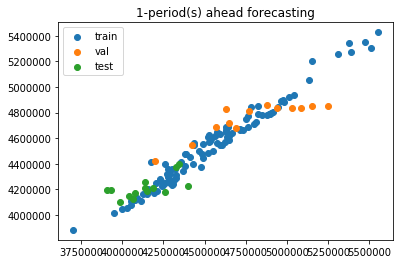

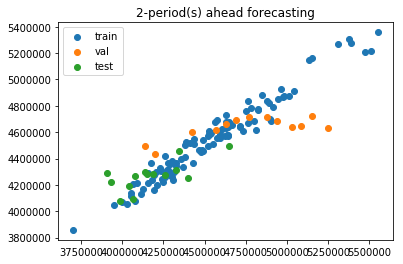

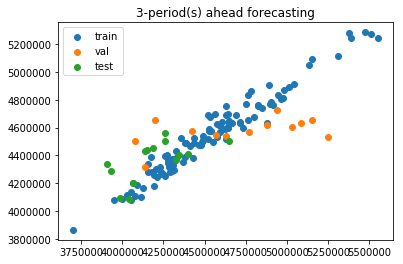

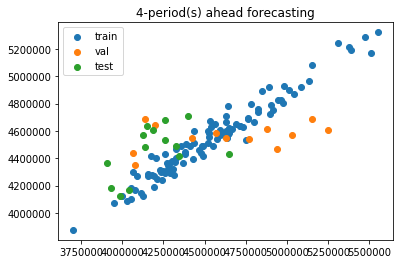

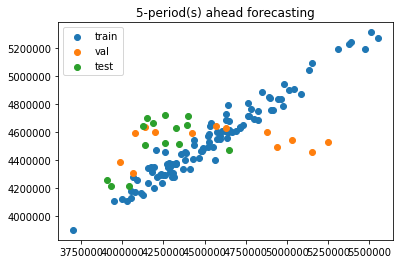

In [25]:
#f, ax = plt.subplots(nrows=3,ncols=2)
for t in range(0,tau):
    plt.scatter(y_train["target_t" + str(t)], train_pred[:,t], label="train")
    plt.scatter(y_val["target_t" + str(t)], val_pred[:,t], label="val")
    plt.scatter(y_test["target_t" + str(t)], test_pred[:,t], label="test")
    plt.title("{}-period(s) ahead forecasting".format(t+1))
    plt.legend()
    plt.show()

### Residual analysis: 1-step ahead residuals

In [26]:
test_resid_1step = y_test["target_t0"]- test_pred[:,0]
test_resid_1step[:5]

date
2018-04-29   -123433.3654
2018-05-06    -94666.7712
2018-05-13    -58282.9174
2018-05-20   -114760.7076
2018-05-27   -106833.8952
Freq: W-SUN, Name: target_t0, dtype: float64

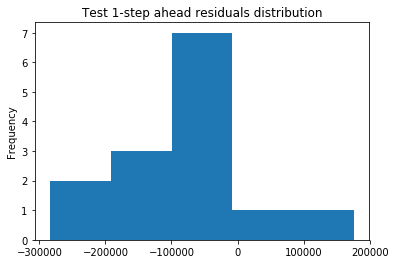

In [27]:
test_resid_1step.plot.hist(bins=5, title="Test 1-step ahead residuals distribution")
plt.show()

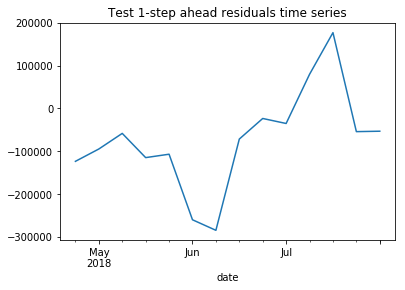

In [28]:
test_resid_1step.plot(title="Test 1-step ahead residuals time series")
plt.show()

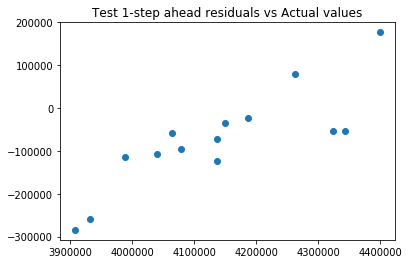

In [29]:
plt.scatter(y_test["target_t0"].values, test_resid_1step.values)
plt.title("Test 1-step ahead residuals vs Actual values")
plt.show()

In [30]:
#test_resid_1step.qqplot(title="Test 1-step ahead residuals time series")
#plt.show()

## Forecasting

In [31]:
forecast_range = pd.date_range(start=np.max(data.index.values), periods=tau, freq="W")
forecast_range

DatetimeIndex(['2018-07-29', '2018-08-05', '2018-08-12', '2018-08-19',
               '2018-08-26'],
              dtype='datetime64[ns]', freq='W-SUN')

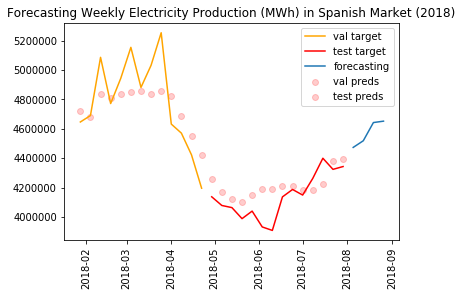

In [32]:
plt.plot(y_val["target_t0"], c="orange", label="val target")
plt.scatter(y_val.index, val_pred[:,0], c="r", alpha=0.2, label="val preds")

plt.plot(y_test["target_t0"], c="r", label="test target")
plt.scatter(y_test.index, test_pred[:,0], c="r", alpha=0.2, label="test preds")
plt.plot(forecast_range[1:], test_pred[-4:,4], label="forecasting")
plt.xticks(rotation=90)
plt.title("Forecasting Weekly Electricity Production (MWh) in Spanish Market (2018)")
plt.legend()